In [41]:
import tensorflow as tf
from tensorflow.keras import backend as K
import keras
import sklearn
import keras_tuner
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras_tuner import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters

# Dosya yolunu belirtin
file_path = 'a.xlsx'

# Verileri Excel'den okuma
Tmax  = pd.read_excel(file_path, usecols='AB', skiprows=0, nrows=4710)
Tmin  = pd.read_excel(file_path, usecols='AC', skiprows=0, nrows=4710)
RH  = pd.read_excel(file_path, usecols='AD', skiprows=0, nrows=4710)
Rs    = pd.read_excel(file_path, usecols='AE', skiprows=0, nrows=4710)
U2    = pd.read_excel(file_path, usecols='AF', skiprows=0, nrows=4710)
ETo   = pd.read_excel(file_path, usecols='AG', skiprows=0, nrows=4710)

# Verileri NumPy dizilerine dönüştürme
nTmax_num = Tmax.to_numpy().flatten()
nTmin_num = Tmin.to_numpy().flatten()
nRH_num = RH.to_numpy().flatten()
nRs_num = Rs.to_numpy().flatten()
nU2_num = U2.to_numpy().flatten()
nETO_num = ETo.to_numpy().flatten()

timesteps = 30
X = []
y = []

for i in range(len(nETO_num)):
    X.append([nTmax_num[i], nTmin_num[i], nRH_num[i], nRs_num[i], nU2_num[i]])
    y.append([nETO_num[i]])

X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)
X.shape[1]

(4708, 5)
(4708, 1)


5

In [42]:
X = np.column_stack((nTmax_num, nTmin_num, nRH_num, nRs_num, nU2_num))
y = nETO_num


In [50]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Modeli oluşturma fonksiyonu
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=hp.Int('units', min_value=5, max_value=10, step=1),
                                 activation='softmax', input_shape=(X.shape[1],)))
    model.add(keras.layers.Dense(units=hp.Int('units', min_value=5, max_value=10, step=1),
                                 activation='softmax'))
    model.add(keras.layers.Dense(units=hp.Int('units', min_value=5, max_value=10, step=1),
                                 activation='softmax'))
    model.add(keras.layers.Dense(units=hp.Int('units', min_value=5, max_value=10, step=1),
                                 activation='softmax'))
    model.add(keras.layers.Dense(1, activation='linear'))
    
    model.compile(
        optimizer=keras.optimizers.SGD(
            hp.Choice('learning_rate', values=[1e-2])),
        loss='mean_squared_error',
        metrics=[
            'mean_absolute_error',
            'mean_squared_error',
            tf.keras.metrics.RootMeanSquaredError(name='rmse')
        ])
    
    return model

# Hiperparametre araması için RandomSearch kullanımı
tuner = BayesianOptimization(
    build_model,
    objective=keras_tuner.Objective("val_rmse", direction="min"),
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld')

# Arama işlemini başlatma
tuner.search(X, y, epochs=20, validation_split=0.2)

# En iyi modeli alma
best_model = tuner.get_best_models(num_models=1)[0]

Trial 20 Complete [00h 00m 07s]
val_rmse: 1.4309792518615723

Best val_rmse So Far: 1.39897882938385
Total elapsed time: 00h 02m 26s


In [51]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

# En iyi modeli daha fazla eğitme
best_model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))


train_loss, train_mae, train_mse, train_rmse = best_model.evaluate(x_train, y_train, verbose=0)
test_loss, test_mae, test_mse, test_rmse = best_model.evaluate(x_test, y_test, verbose=0)

# Tahmin yapma
predictions = best_model.predict(X)

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4048 - mean_absolute_error: 0.9678 - mean_squared_error: 1.4048 - rmse: 1.1849 - val_loss: 1.4952 - val_mean_absolute_error: 0.9959 - val_mean_squared_error: 1.4952 - val_rmse: 1.2228
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3499 - mean_absolute_error: 0.9429 - mean_squared_error: 1.3499 - rmse: 1.1616 - val_loss: 1.4556 - val_mean_absolute_error: 0.9794 - val_mean_squared_error: 1.4556 - val_rmse: 1.2065
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3071 - mean_absolute_error: 0.9236 - mean_squared_error: 1.3071 - rmse: 1.1431 - val_loss: 1.4007 - val_mean_absolute_error: 0.9633 - val_mean_squared_error: 1.4007 - val_rmse: 1.1835
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2683 - mean_absolute_error: 0.9131 - mean_squared_error: 1.2683 - rmse: 1.1259 - val_loss: 1.3205 - val_mean_absolute_error: 0.9247 - val_mean_squared_error: 1.3205 - val_rmse: 1.1491
Epoch 5/100


In [47]:
print(f"Train MAE: {train_mae}")
print(f"Train MSE: {train_mse}")
print(f"Train RMSE: {train_rmse}")

print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")

Train MAE: 0.1839006394147873
Train MSE: 0.06585834920406342
Train RMSE: 0.2566288113594055
Test MAE: 0.20088604092597961
Test MSE: 0.0877639576792717
Test RMSE: 0.2962498366832733


In [48]:
# Control
for i in range(400):
    print(f"Gerçek ETo: {y[i]}, Tahmin edilen ETo: {predictions[i][0]}")

Gerçek ETo: 2.74, Tahmin edilen ETo: 2.8240909576416016
Gerçek ETo: 4.3, Tahmin edilen ETo: 4.161427021026611
Gerçek ETo: 2.94, Tahmin edilen ETo: 2.8996851444244385
Gerçek ETo: 2.49, Tahmin edilen ETo: 2.267054319381714
Gerçek ETo: 2.21, Tahmin edilen ETo: 2.0304460525512695
Gerçek ETo: 3.34, Tahmin edilen ETo: 3.263918161392212
Gerçek ETo: 3.4, Tahmin edilen ETo: 3.518827199935913
Gerçek ETo: 3.08, Tahmin edilen ETo: 3.1875624656677246
Gerçek ETo: 1.75, Tahmin edilen ETo: 1.84019935131073
Gerçek ETo: 3.21, Tahmin edilen ETo: 3.38031005859375
Gerçek ETo: 2.24, Tahmin edilen ETo: 2.0178306102752686
Gerçek ETo: 3.1, Tahmin edilen ETo: 2.9094347953796387
Gerçek ETo: 3.38, Tahmin edilen ETo: 3.2603914737701416
Gerçek ETo: 2.89, Tahmin edilen ETo: 3.0728931427001953
Gerçek ETo: 2.87, Tahmin edilen ETo: 2.7326908111572266
Gerçek ETo: 3.46, Tahmin edilen ETo: 3.4084274768829346
Gerçek ETo: 4.03, Tahmin edilen ETo: 4.007591247558594
Gerçek ETo: 4.52, Tahmin edilen ETo: 4.489726543426514
Gerçe

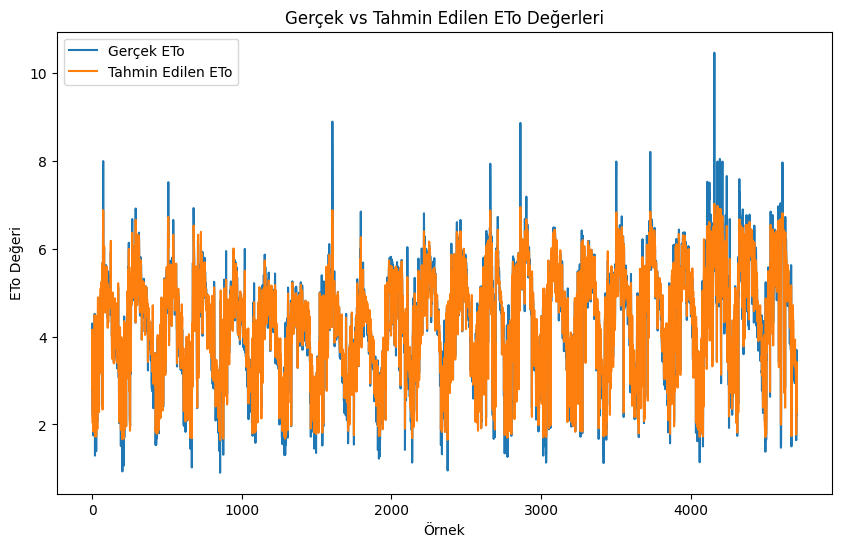

In [49]:
import matplotlib.pyplot as plt

# Gerçek ve tahmin edilen değerleri görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(y, label='Gerçek ETo')
plt.plot(predictions, label='Tahmin Edilen ETo')
plt.legend()
plt.xlabel('Örnek')
plt.ylabel('ETo Değeri')
plt.title('Gerçek vs Tahmin Edilen ETo Değerleri')
plt.show()
